In [1]:
import numpy as np;
import time;

In [2]:
import matplotlib.pyplot as plt;
%matplotlib inline

In [3]:
from RBComb.SerialBridge import *
from RBComb.RBComb576 import *
from RBComb.Helper.BoardPinout import *
from RBComb.Helper.BoardUnits import *;
from RBComb.Helper.FunctionInterpolator import *

In [5]:
# Note: the correct baud rate is 5'000'000 but it is not supported in Mac OS X
# The solution is to modify the serial port driver so it aliases ("pretends") to be working at a standard
# rate of 300, but in reality it works at 5000000. This is done by modifying /Library/Extensions/FTDIUSBSerialDriver.kext
# following the guide https://www.ftdichip.com/Support/Documents/TechnicalNotes/TN_105%20Adding%20Support%20for%20New%20FTDI%20Devices%20to%20Mac%20Driver.pdf
# And subsequently disabling the "trusted platform" features of mac since it would no longer accept the modified extension
currentBridge = SerialBridge('/dev/tty.usbserial-FT3HPF65B', True, 300);

In [6]:
# Construct RBComb576
rbComb = RBComb576(currentBridge);

In [7]:
# Construct helper objects:
pinout = BoardPinout();
units = BoardUnits();

In [14]:
# We must make sure the clock is disabled, otherwise the boards cannot hear us
rbComb.disableClock()

# Select all boards
rbComb.selectAllBoards()

# Select the high gain setting
rbComb.setGain(True);

In [15]:
# Load A and B interpolation functions from the file (generated from tight binding)
coefficientsA = np.load('./data/coefficients_A.npy')
coefficientsB = np.load('./data/coefficients_B.npy')

In [16]:
# Calculate time series for plotting purposes:
interpolator = FunctionInterpolator();
protocolA = interpolator.performValidation(coefficientsA);
protocolB = interpolator.performValidation(coefficientsB);

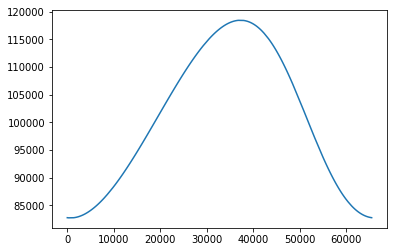

In [17]:
# Plot braiding protocol A
plt.plot(protocolA)

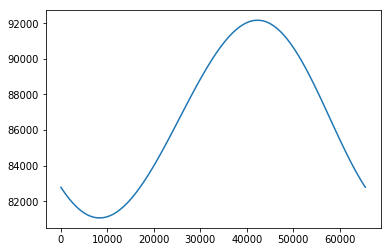

In [18]:
# Plot braiding protocol B
plt.plot(protocolB)

In [19]:
# Upload function to the device
for i in range(576):
    rbComb.setTaylorCoefficients(i, False, coefficientsA);
    rbComb.setTaylorCoefficients(i, True, coefficientsB);

In [20]:
# In the previous cell we load the same coefficients to all outputs, 
# but we could use different coefficients for every output and board
# This would be accomplished by:
# for j in range(10):
#     rbComb.selectBoard(j);
#     for i in range(576):
#         rbComb.setTaylorCoefficients(i, False, coefficientsA[j][i]);
#         rbComb.setTaylorCoefficients(i, True, coefficientsB[j][i]);
# Assuming that coefficientsA and coefficientsB are arrays of arrays of (arrays of coefficients)

In [21]:
# Protocol sequence:
# Configure the braiding sequence
protocolLength = 5;
sequenceOrder = [0,0,1,1,0];
sequenceAB = [0,1,0,1,1];

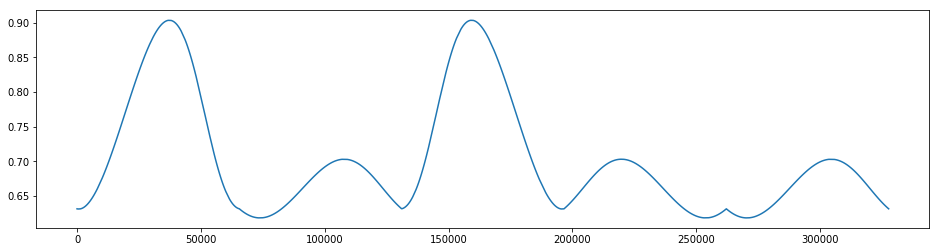

In [22]:
# Plot the full braiding sequence:
fullProtocol = None;
for i in range(protocolLength):
        if sequenceAB[i] == 0:
            currentSequence = protocolA;
        else:
            currentSequence = protocolB;
            
        if sequenceOrder[i]:
            currentSequence = np.flip(currentSequence,0);
        
        if fullProtocol is None:
            fullProtocol = currentSequence;
        else:
            fullProtocol = np.append(fullProtocol, currentSequence);
fig = plt.figure()
ax = fig.add_subplot(111)
ax.figure.set_size_inches(16, 4)
ax.plot(np.array(fullProtocol, dtype='float')/interpolator.yScaling);

In [23]:
# Configure the braiding sequence
rbComb.setBraidingLength(protocolLength)
rbComb.setBraidingOrder(sequenceOrder)
rbComb.setBraidingHold([0,0,0,0,0]) # Setting a 1 here allows to freeze the output for a step. Not used now.
rbComb.setBraidingAB(sequenceAB)

In [24]:
# Braiding speed
rbComb.setBraidingSpeed(units.convertBraidingDurationToIntegerSpeed(8e-3)); # 8 miliseconds per braiding step

In [25]:
# Parameters for the sine generators
frequency1 = units.convertFrequencyHzToInteger(21000);   # Frequency first vortex mode
frequency2 = units.convertFrequencyHzToInteger(21000);   # Frequency second vortex mode
frequency3 = units.convertFrequencyHzToInteger(21000);   # Frequency third vortex mode

amplitudes1 = np.array([20000]*576); # Mode shape first vortex mode
amplitudes2 = np.array([0]*576);     # Mode shape second vortex mode
amplitudes3 = np.array([0]*576);     # Mode shape third vortex mode

In [26]:
# Configure the two sine generators
rbComb.setPhase(0,0)
rbComb.setPhase(1,0)
rbComb.setPhase(2,0)

rbComb.setFrequency(0,frequency1)
rbComb.setFrequency(1,frequency2)
rbComb.setFrequency(2,frequency3)

for i in range(576):
    rbComb.setAmplitude(0,i, amplitudes1[0]);
    rbComb.setAmplitude(1,i, amplitudes2[0]);
    rbComb.setAmplitude(2,i, amplitudes3[0]);
    rbComb.setAmplitude(3,i,0);

In [42]:
# Ramp up the output
rbComb.outputRampUp();
rbComb.setCurrentState([0,0,0,0,0]); # Everything is frozen

rbComb.enableClock()
time.sleep(4);
rbComb.disableClock()

In [45]:
# Configure the experiment:
pumpingDuration = units.convertTimeToSteps(40e-3); # Pump for 40 miliseconds

# Initially the 4 sine generators are on and the interpolator is off:
rbComb.setCurrentState([1,1,1,1,0]);

# After pumpingDuration clock cycles, we will turn off the sine generators and turn on the braiding:
rbComb.setNextState([0,0,0,0,1], pumpingDuration);

# Make sure the system starts from the beginning of the braiding sequence:
rbComb.setBraidingFrame(0)

In [46]:
# Run experiment
rbComb.enableClock()
time.sleep(0.5);
rbComb.disableClock()

In [23]:
# Ramp down the output
rbComb.outputRampDown();
rbComb.enableClock()
time.sleep(4);
rbComb.disableClock()

In [24]:
currentBridge.closeConnection()